In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import datetime
from pytz import timezone
import pytz
import time

import statsmodels.formula.api as sm
from linearmodels.panel import PanelOLS, FamaMacBeth
from patsy              import dmatrices

from helpers import plot_func_p1, ols_coef, get_vol, plot_func_p3

## 1.	Create a visualization to show the following in 15-minute intervals for each stock in the included data -
    a.	Average spread (Ask - Bid), 
    b.	Average total bin volume as a percent of the full day’s volume 
    c.	Volume-weighted average price (VWAP)


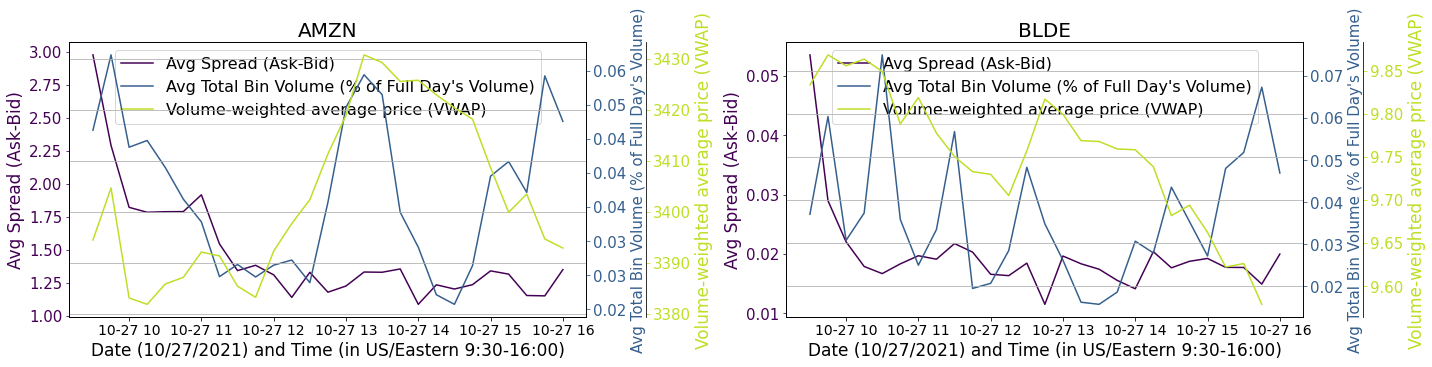

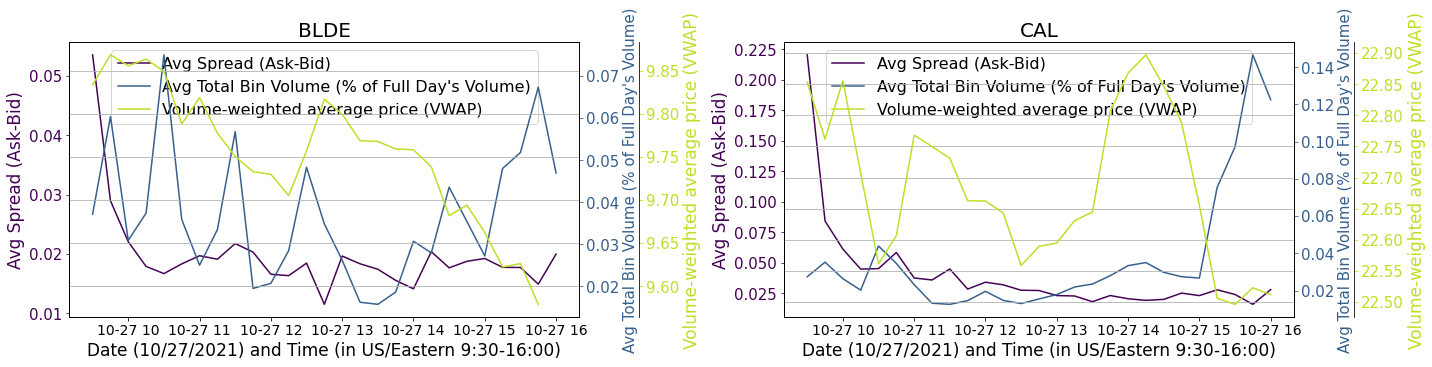

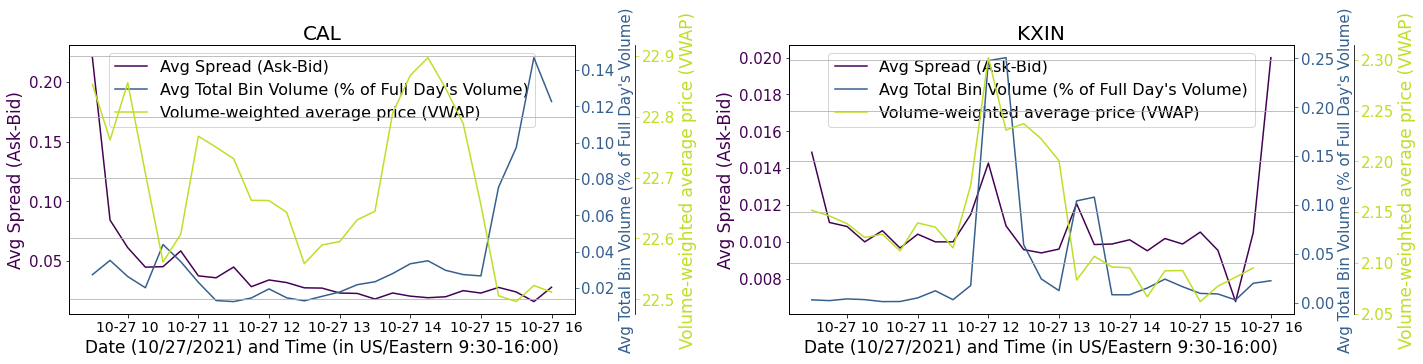

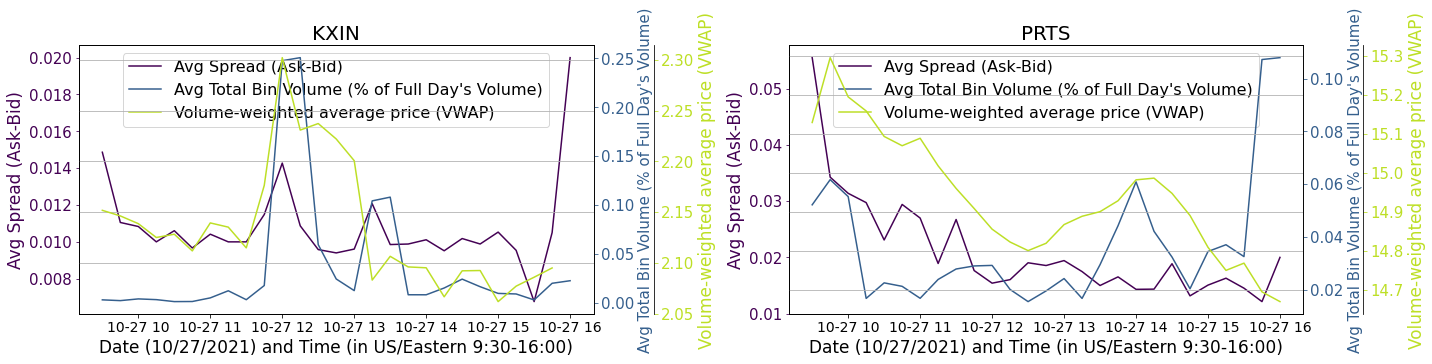

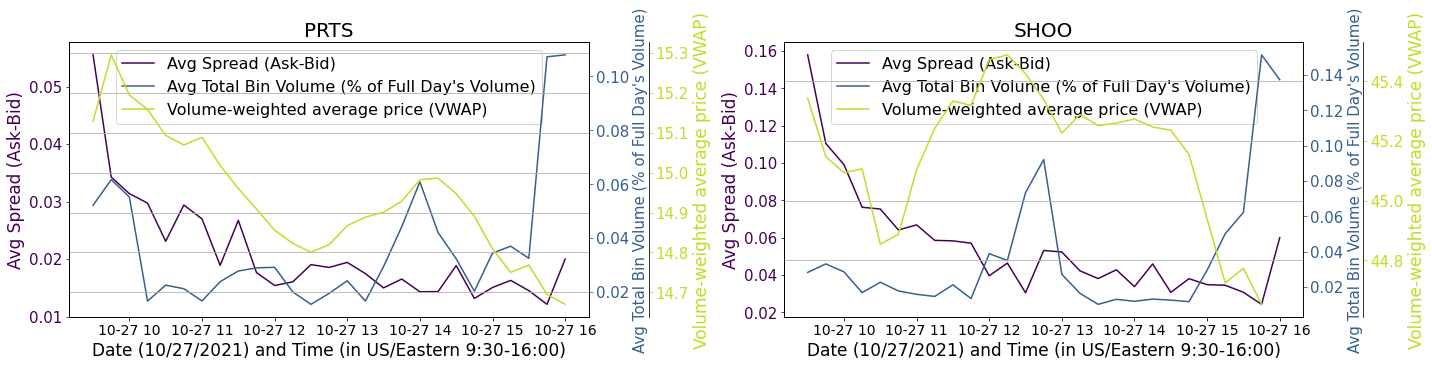

In [2]:
# read stock and convert 'timestamp' from mili-seconds to seconds
ticker_list = ['AMZN','BLDE','CAL','KXIN','PRTS','SHOO','TECH','TTGT','XOS', 'SMTC']
p1_final = []
for ticker in ticker_list:
    stock_i = pd.read_csv(ticker+'.csv')
    stock_i['timestamp'] = round(stock_i['timestamp']/1000)

    # sort 'timestamp', create a date index in Eastern time, drop 'timestamp', and keep necessary columns
    stock_i = stock_i.sort_values(by='timestamp')
    stock_i.index = [datetime.datetime.fromtimestamp(i, datetime.timezone.utc) for i in stock_i['timestamp']]
    stock_i.index = stock_i.index.tz_convert('US/Eastern')
    stock_i = stock_i.drop('timestamp', axis=1)
    stock_i = stock_i[[' bid_price',' ask_price',' nbb_agg_size',' nbo_agg_size',\
                       ' trade_price',' trade_size',' volume',' vwap']].ffill()

    # throw away observations before 9:30 and after 16:00 eastern standard time
    stock_i = stock_i[stock_i.index>='2021-10-27 09:30:00-04:00']
    stock_i = stock_i[stock_i.index<='2021-10-27 16:00:00-04:00']
    
    # midpoint price:
    stock_i[' mid price'] = (stock_i[' bid_price'] + stock_i[' ask_price'])/2
    
    # a)
    # create 15 min interval and get avg:
    p1 = stock_i[[' ask_price',' bid_price',' volume']].resample('15min').mean()
    p1[' avg_spread'] = p1[' ask_price'] - p1[' bid_price']

    # b)
    p1[' avg_total_bin_volume'] = (p1[' volume'] / p1.loc[:,' volume'][-1]).diff(1)
    p1.loc['2021-10-27 09:30:00-04:00',' avg_total_bin_volume'] = 1-p1[' avg_total_bin_volume'].sum() #dropped bcuz of diff(1) from above

    # c1: cumulitive VWAP from start of day
    #p1_c = stock_i[[' vwap']].resample('15min').last()

    # c2: VWAP during 15min interval
    first_volume = stock_i[' volume'].values[0] #dont want to drop the first tick's volume
    stock_i[' volume'] = stock_i[' volume'].diff(1) #incremental volume = diff(cumulitive volume)
    stock_i.iloc[0, stock_i.columns.get_loc(' volume')] = first_volume #add back the first tick's volume

    #vwap = sum(price_t * w_t) --> where w_t == volume_t/sum(volume)
    #vwap = sum(price_t * [volume_t/sum(volume)])
    #vwap = sum(price_t * volume_t) / sum(volume) 
    stock_i[' price x volume'] = stock_i[' mid price'] * stock_i[' volume']
    p1_c = stock_i[[' price x volume',' volume']].resample('15min').sum()
    p1_c[' vwap'] = p1_c[' price x volume'] / p1_c[' volume']
    p1_c = p1_c[[' vwap']]
    p1 = pd.merge(p1, p1_c, left_index=True, right_index=True)

    p1.index.name = ticker
    p1_final.append(p1.copy())

# now plot:
for i in range(int(len(p1_final)/2)):    
    # Plot code below:
    fig, (host1,host2) = plt.subplots(1,2,figsize=(20,5))
    host = host1
    plot_func_p1(p1_final[i],host,fig)

    i+=1
    host = host2
    plot_func_p1(p1_final[i],host,fig)

    plt.show()



## 2. Write the most efficient code you can to build a cross sectional linear regression model. You will need to start by creating the following variables.
### a.	The response variable will be: 
##### ●	Normalized mid price return from the time of trade to the midpoint price at 10 seconds after the time of a trade. 
##### ○	Formula: ( (Mid (t+10) – Mid (t)) / Mid(t) ) / (Ask (t) – Bid(t)) 
##### ○	Hint: Mid (t+10) is the prevailing midpoint price at time t+10. This would be the current price at the time 10 seconds after the trade.
##### ○	Throw away observations where spread (ask price – bid price) is zero or negative. 

### b.	Predictors are:
##### ●	Bid Offer Imbalance, calculated as: (Nbb_agg_size – Nbo_agg_size )/(Nbb_agg_size + Nbo_agg_size) 
##### ●	Trade sign: 
##### ○	1 if the last trade price is above the average of bid and ask price
##### ○	-1 if the last trade price is below the average of bid and ask price
##### ●	Trade Size imbalance over the last 10 seconds: Trade size imbalance for any period can be calculated as: Sum ( Trade Sign x Trade Size ) 


In [3]:
# read stock and convert 'timestamp' from mili-seconds to seconds
for ticker in ticker_list:
    stock_i = pd.read_csv(ticker+'.csv')
    stock_i['timestamp'] = round(stock_i['timestamp']/1000)

    # sort timestamp, create a date index (localize in UTC, convert to ET), drop 'timestamp', & keep necessary cols
    stock_i = stock_i.sort_values(by='timestamp')
    stock_i.index = [datetime.datetime.fromtimestamp(i, datetime.timezone.utc) for i in stock_i['timestamp']]
    stock_i.index = stock_i.index.tz_convert('US/Eastern')
    stock_i = stock_i.drop('timestamp', axis=1)
    stock_i = stock_i[[' bid_price',' ask_price',' nbb_agg_size',' nbo_agg_size',\
                       ' trade_price',' trade_size',' volume',' vwap']].ffill()

    # throw away observations before 9:30 and after 16:00 eastern standard time
    stock_i = stock_i[stock_i.index>='2021-10-27 09:30:00-04:00']
    stock_i = stock_i[stock_i.index<='2021-10-27 16:00:00-04:00']
    
    # midpoint price:
    stock_i[' mid price'] = (stock_i[' bid_price'] + stock_i[' ask_price'])/2
    #########################################
    #########################################
    ### Response Variable ###
    # returns: create 10 sec interval and get last
    p2 = stock_i[[' mid price']].resample('10s').last().ffill()

    p2 = p2.pct_change(1)#.dropna()

    # avg_spread: create 10 sec interval and get mean
    p1 = stock_i[[' ask_price',' bid_price']].resample('10s').mean().ffill()
    p1[' avg_spread'] = p1[' ask_price'] - p1[' bid_price']

    # merge returns and avg_spread, then throw away obs with non-positive spread
    p2 = p2.merge(p1, left_index=True, right_index=True)
    p2 = p2[p2[' avg_spread']>0]

    # return (given formula)
    p2[' returns'] = p2[' mid price'] / p2[' avg_spread']
    ret_10s = p2[[' returns']].copy()
    #ret_10s.plot();
    #########################################
    #########################################
    ### Predictor 1: Bid Offer Imbalance ###
    # formula: (Nbb_agg_size – Nbo_agg_size )/(Nbb_agg_size + Nbo_agg_size) 
    # ie, (Bid size - Ask size) / entire market size --> if this number is positive, more buyers (price should go up)

    # avg_spread: create 10 sec interval and get sum
    p2 = stock_i[[' nbb_agg_size',' nbo_agg_size']].resample('10s').sum().fillna(0)
    p2[' bid_offer_imbal'] = (p2[' nbb_agg_size'] - p2[' nbo_agg_size'])
    p2[' bid_offer_imbal'] /= (p2[' nbb_agg_size'] + p2[' nbo_agg_size'])

    # if nbb_agg_size & nbo_agg_size are both 0, will get nan here (fill nans with 0)
    bid_offer_imbal = p2[[' bid_offer_imbal']].fillna(0).copy()
    #p2.plot()
    #########################################
    #########################################
    ### Predictor 2: Trade sign: 
    ##### ○ 1 if the last trade price is above the average of bid and ask price
    ##### ○ -1 if the last trade price is below the average of bid and ask price

    # last trade price
    p2 = stock_i[[' trade_price']].resample('10s').last().ffill()

    # merge trade price and avg_spread, then throw away obs with non-positive spread
    p2 = p2.merge(p1, left_index=True, right_index=True)
    p2 = p2[p2[' avg_spread']>0]

    # get avg of bid and ask price
    p2[' trade_sign'] = np.where(p2[' trade_price'] > ((p2[' bid_price']+p2[' ask_price'])/2), 1, 0)
    p2[' trade_sign2'] = np.where(p2[' trade_price'] < ((p2[' bid_price']+p2[' ask_price'])/2), -1, 0)
    p2[' trade_sign'] = p2[' trade_sign'] + p2[' trade_sign2']

    trade_sign = p2[[' trade_sign']].copy()
    #########################################
    #########################################
    ### Predictor 3: Trade Size imbalance over the last 10 seconds
    ##### Sum ( Trade Sign x Trade Size ) 

    # trade sign
    p2 = stock_i[[' trade_price',' trade_size']].ffill()
    p2[' avg_price'] = (stock_i[' ask_price'] + stock_i[' bid_price'])/2

    p2[' trade_sign'] = np.where(p2[' trade_price'] > p2[' avg_price'], 1, 0)
    p2[' trade_sign2'] = np.where(p2[' trade_price'] < p2[' avg_price'], -1, 0)
    p2[' trade_sign'] = p2[' trade_sign'] + p2[' trade_sign2']
    p2 = p2[[' trade_sign',' trade_size']]

    ### multiply with trade size
    p2[' trade_size_imbal'] = p2[' trade_sign'] * p2[' trade_size']

    # create 10 sec interval and compute sum
    p2 = p2[[' trade_size_imbal']].resample('10s').sum().fillna(0)
    trade_size_imbal = p2.copy()
    #trade_size_imbal.plot()
    #########################################
    #########################################
    # merge everything together:
    p2 = ret_10s.merge(bid_offer_imbal, left_index=True, right_index=True)
    p2 = p2.merge(trade_sign, left_index=True, right_index=True)
    p2 = p2.merge(trade_size_imbal, left_index=True, right_index=True)
    #########################################
    #########################################
    # shift predictor vairables up one (real time prediction)
    p2[[' bid_offer_imbal',' trade_sign',' trade_size_imbal']] = p2[[' bid_offer_imbal',
                                                                     ' trade_sign',' trade_size_imbal']].shift(1)
    p2[' stock'] = ticker
    #########################################
    #########################################
    # Base case: create a dataframe to house the data
    if ticker == ticker_list[0]:
        stock_i_variables = p2.copy()
    else: #else case: stack data on top of each other to run cross-sectional regression
        stock_i_variables = pd.concat([stock_i_variables, p2], ignore_index=False, axis=0)

# there are only 10 occurance of nan values (once for each stock between 9:30:00 and 9:30:10)
stock_i_variables = stock_i_variables.dropna()
stock_i_variables = stock_i_variables.reset_index(drop=False)
stock_i_variables.columns = ['index', 'returns', 'bid_offer_imbal', 'trade_sign', 'trade_size_imbal', 'stock']
stock_i_variables =  stock_i_variables.set_index(['stock','index'])
stock_i_variables['intercept'] = 1
stock_i_variables


returns  bid_offer_imbal  trade_sign  \
stock index                                                              
AMZN  2021-10-27 09:30:10-04:00 -0.000117         0.025051        -1.0   
      2021-10-27 09:30:20-04:00  0.000448         0.062344         1.0   
      2021-10-27 09:30:30-04:00  0.000301        -0.423687         1.0   
      2021-10-27 09:30:40-04:00 -0.000282        -0.068273        -1.0   
      2021-10-27 09:30:50-04:00  0.000030        -0.007937        -1.0   
...                                   ...              ...         ...   
SMTC  2021-10-27 15:59:20-04:00  0.004912         0.229630         1.0   
      2021-10-27 15:59:30-04:00 -0.001241        -0.272727        -1.0   
      2021-10-27 15:59:40-04:00 -0.001102        -0.656716        -1.0   
      2021-10-27 15:59:50-04:00 -0.006353        -0.130435        -1.0   
      2021-10-27 16:00:00-04:00  0.000000         0.094851        -1.0   

                                 trade_size_imbal  intercept  
stock index                                                   
AMZN  2021-10-27 09:30:10-04:00            -654.0          1  
      2021-10-27 09:30:20-04:00             -82.0          1  
      2021-10-27 09:30:30-04:00            2259.0          1  
      2021-10-27 09:30:40-04:00            -766.0          1  
      2021-10-27 09:30:50-04:00            -115.0          1  
...                                           ...        ...  
SMTC  2021-10-27 15:59:20-04:00             369.0          1  
      2021-10-27 15:59:30-04:00             138.0          1  
      2021-10-27 15:59:40-04:00             197.0          1  
      2021-10-27 15:59:50-04:00              97.0          1  
      2021-10-27 16:00:00-04:00             734.0          1  

[23400 rows x 5 columns]

In [4]:
# Run cross-sectional regression: group by time (fama-macbeth style)
# We can use pre-programmed routines or build our own. 
#
#
# First, our own

res = (stock_i_variables.groupby('index').apply(ols_coef,'returns~intercept+bid_offer_imbal+trade_sign+trade_size_imbal'))
T = 2340

print('Mean Return: ' , str(res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].mean())+'\n', 
      'Std Dev:      ', str(res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].std())+'\n', 
      'Sharpe Ratio ', str(res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].mean()/
                       res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].std())+'\n',
      't-stat:      ', str(T**.5*(res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].mean())/
                      res[['intercept','bid_offer_imbal','trade_sign','trade_size_imbal']].std()), sep="\n")


Mean Return: 
intercept          -0.000447
bid_offer_imbal     0.002564
trade_sign          0.000905
trade_size_imbal   -0.000002
dtype: float64

Std Dev:      
intercept           0.008161
bid_offer_imbal     0.169636
trade_sign          0.020557
trade_size_imbal    0.000315
dtype: float64

Sharpe Ratio 
intercept          -0.054757
bid_offer_imbal     0.015117
trade_sign          0.044015
trade_size_imbal   -0.007049
dtype: float64

t-stat:      
intercept          -2.648805
bid_offer_imbal     0.731248
trade_sign          2.129150
trade_size_imbal   -0.340965
dtype: float64


In [5]:
# Then, the pre-programmed
y, X  = dmatrices('returns~bid_offer_imbal+trade_sign+trade_size_imbal', stock_i_variables,return_type='dataframe')

res1 = FamaMacBeth(y,X).fit()
res1

/var/folders/zq/mnsphq4d0n7110tsx_3cg6wm0000gn/T/ipykernel_24499/1326754984.py:4: MissingValueWarning: 7 of the time-series regressions cannot be estimated due to deficient rank.
  res1 = FamaMacBeth(y,X).fit()


Dep. Variable:,returns,R-squared:,-0.0011
Estimator:,FamaMacBeth,R-squared (Between):,-1.2590
No. Observations:,23400,R-squared (Within):,-0.0010
Date:,"Fri, Nov 04 2022",R-squared (Overall):,-0.0011
Time:,21:48:41,Log-likelihood,3.229e+04
Cov. Estimator:,Fama-MacBeth Standard Cov,,
,,F-statistic:,-8.4302
Entities:,10,P-value,1.0000
Avg Obs:,2340.0,Distribution:,"F(3,23396)"
Min Obs:,2340.0,,
Max Obs:,2340.0,F-statistic (robust):,1.5334


# 3. Calculate the 15-second volatility (standard deviation of mid price returns) in each 30 minute interval. Present the volatility in annualized terms. 

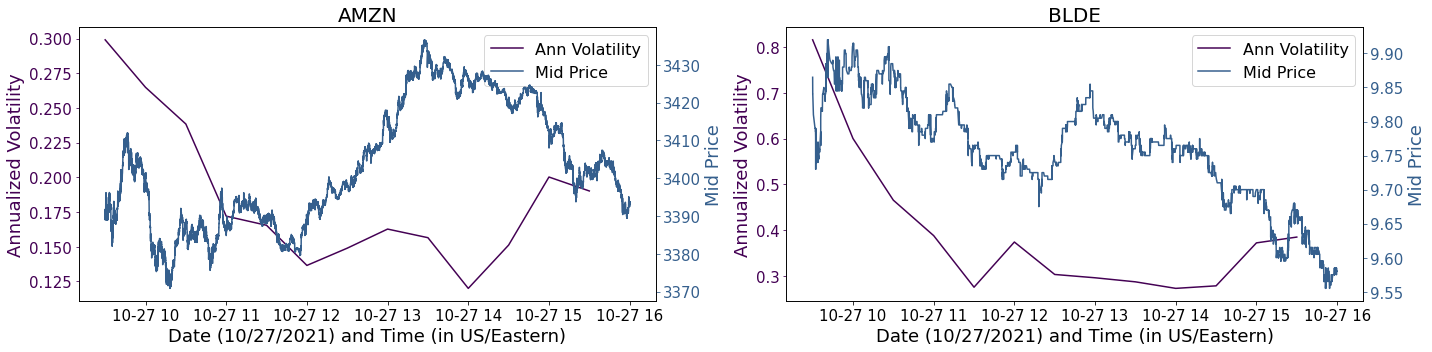

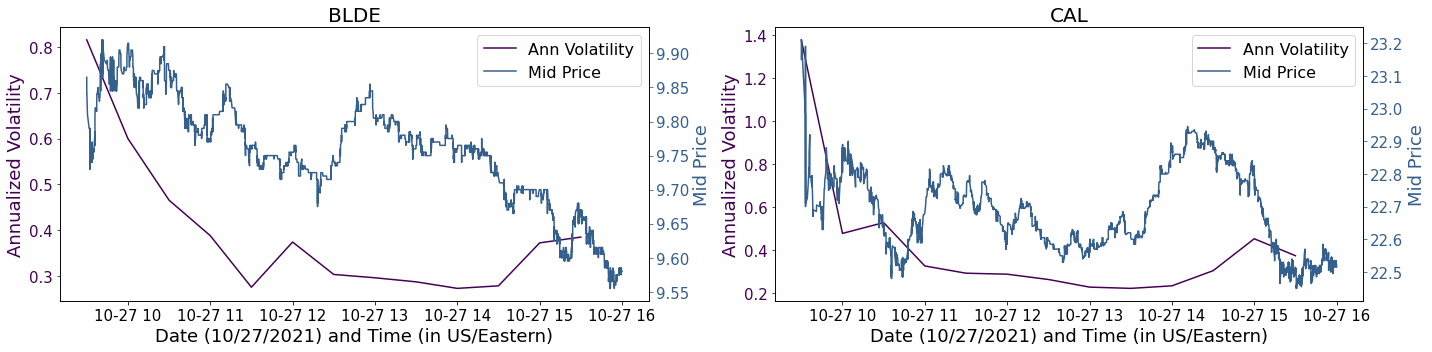

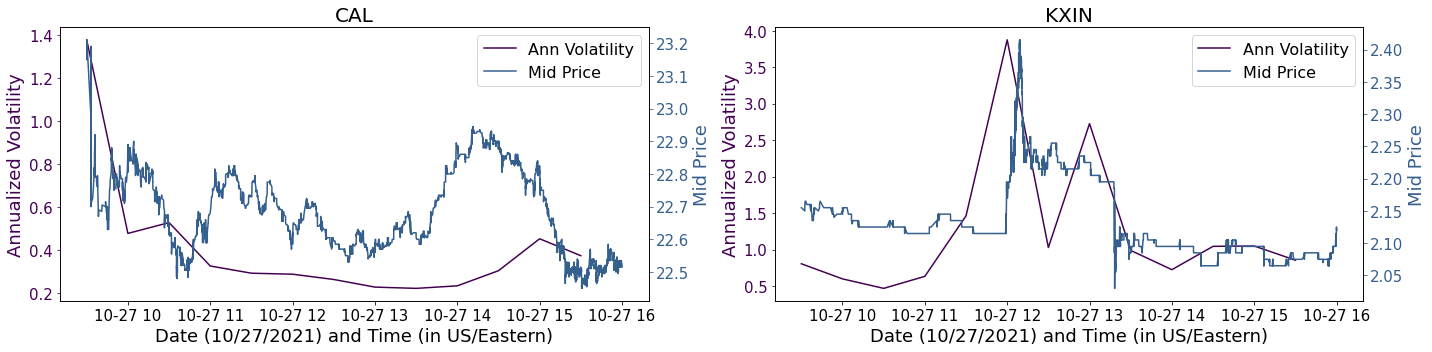

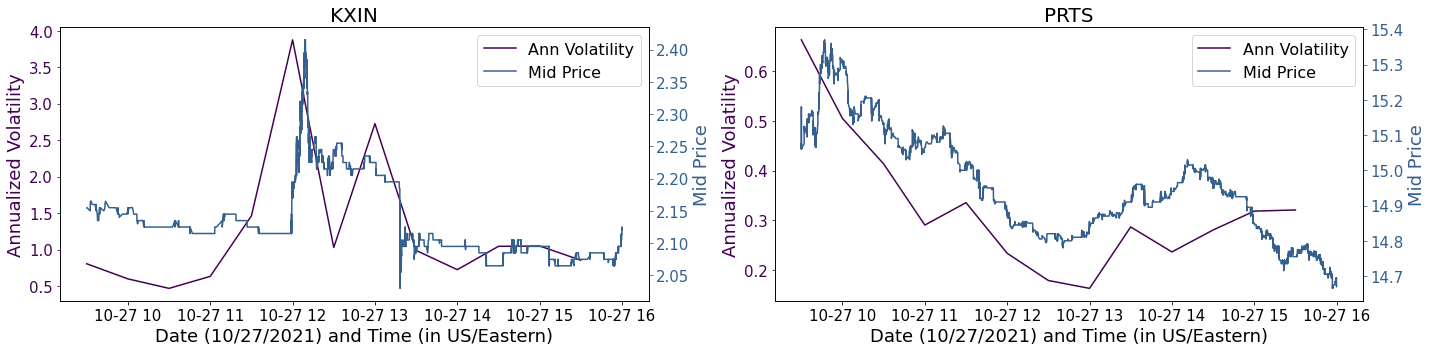

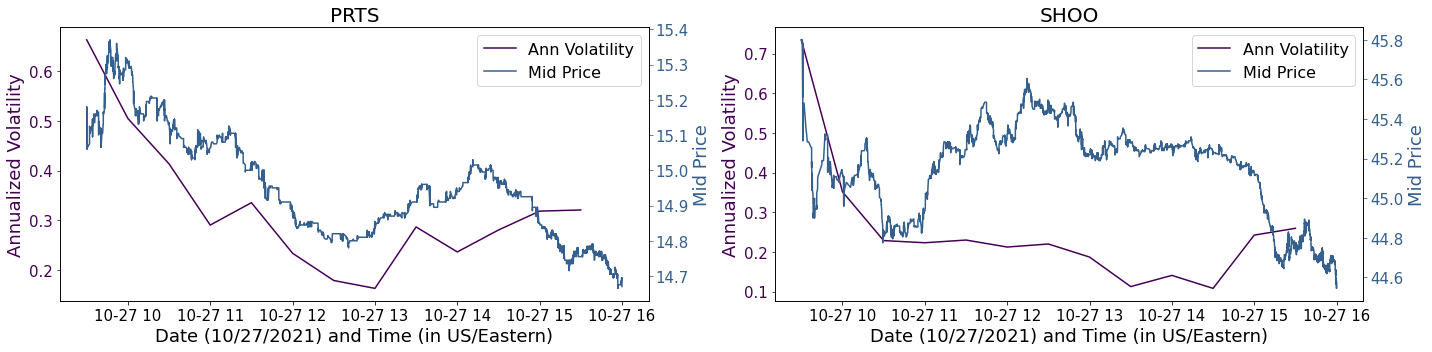

In [6]:
lookback_freq = '30min'
vol_ann = []
stock_ls = []
for ticker in ['AMZN','BLDE','CAL','KXIN','PRTS','SHOO','TECH','TTGT','XOS', 'SMTC']:
    vol_ann_i, stock_i = get_vol(ticker, lookback_freq)
    vol_ann_i.index.name = ticker
    vol_ann.append(vol_ann_i)
    stock_ls.append(stock_i)
    
# now plot:
for i in range(int(len(vol_ann)/2)):    
    # Plot code below:
    fig, (host1,host2) = plt.subplots(1,2,figsize=(20,5))
    host = host1
    plot_func_p3(vol_ann[i],stock_ls[i],host,fig)

    i+=1
    host = host2
    plot_func_p3(vol_ann[i],stock_ls[i],host,fig)

    plt.show()
